# Packages

In [1]:
import os
from tqdm import tqdm
import pickle
import random
from typing import List, Dict, Tuple
from anndata import AnnData, concat
import scanpy as sc
import squidpy as sq
import time

import pandas as pd
import numpy as np
import math
import scipy
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import umap
from PIL import Image, ImageFilter

from molmass import Formula
import metaspace
from scipy.cluster.hierarchy import linkage
from sklearn.cluster import AgglomerativeClustering
from scipy import stats
# from statannotations.Annotator import Annotator
import networkx as nx

from collections import defaultdict

/home/trose/.conda/envs/metabolomics2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/trose/.conda/envs/metabolomics2/lib/python3.10/site-packages/linex2/parser.py:22: RuntimeWarning: Package 'lynx' (LipidLynxX) not available. Lipid name conversions will not be possible.
  warnings.warn(


In [3]:
import utils
from coloc_utils import *
from config import store_dir, data_dir, date_key, enrichment_dir, module_dir
%load_ext autoreload
%autoreload 2

# Figure 3

In [ ]:
ao = pickle.load(open(os.path.join(store_dir, 'single_pixel_adata_combined.pickle'), "rb"))
ao2 = pickle.load(open(os.path.join(store_dir, 'single_pixel_adata_combined_bbknn.pickle'), "rb"))

In [5]:
adcbbknn = pickle.load(open(os.path.join(store_dir, 'single_pixel_adata_Brain_bbknn.pickle'), "rb"))
adcbbknn = adcbbknn[adcbbknn.obs['ds']!='2017-06-09_07h12m31s', :]

In [6]:
tmp = adcbbknn.obs[adcbbknn.obs['leiden']=='7']
tmp = min_pixels(tmp, min_pixels=100)
tmp['ds'] = tmp['ds'].astype(str)
dsl = set(tmp['ds'])
sm = metaspace.SMInstance()

sc.tl.rank_genes_groups(adcbbknn, groupby='leiden', method='t-test')
tmp = sc.get.rank_genes_groups_df(adcbbknn, '7')
mol = tmp['names'][0]
print(mol)

image_l = {}
for dsid in dsl:
    ds = sm.dataset(id=dsid)
    image_l[dsid] = ds.isotope_images(mol, '+H')[0]

/home/trose/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/trose/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/trose/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/trose/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/trose/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  ut

C39H79N2O6P


In [19]:
len(ao.obs['ds'].unique())

174

In [7]:
tmp = sc.get.rank_genes_groups_df(adcbbknn, '7')
tmp = tmp[(tmp['logfoldchanges'] > 2) & (tmp['pvals_adj'] <= 0.05)]
# tmp[['names']].rename(columns={'names': 'formula'}).to_csv(os.path.join(store_dir, f'enrichment/single_pixel_brain_cluster.csv'))

In [8]:
# Make image outlines
def image_outline(dsid):
    dummy_image = np.zeros(image_l[dsid].shape)
    tmp = adcbbknn.obs
    tmp = tmp[tmp['ds']==dsid]
    for x,y in zip(tmp['x'], tmp['y']):
        dummy_image[y, x]=1

    dummy_image = ndimage.median_filter(dummy_image, size=(3,3))
    pil_image = Image.fromarray(dummy_image.astype('uint8'))

    # Apply the FIND_EDGES filter to highlight edges
    edge_image = pil_image.filter(ImageFilter.FIND_EDGES)

    # Convert the result back to a NumPy array
    edge_array = np.array(edge_image)

    return edge_array


In [10]:
def ax_ann(fig, ax, letter='A', xoffset=0, yoffset=0, figleft_align=False, **kwargs):

    axes_position = ax.get_position()
    # Extract position and size information
    left, bottom, width, height = axes_position.bounds
    if figleft_align:
        fig.text(0.+xoffset, bottom+height+yoffset, letter, **kwargs)
    else:
        fig.text(left+xoffset, bottom+height+yoffset, letter, **kwargs)

def draw_umapaxis(ax, length_mul=.1):
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    
    deltax = xlims[1] - xlims[0]
    deltay = ylims[1] - ylims[0]
    
    # X-Annotation
    ax.annotate('', xy=(xlims[0]+length_mul*deltax, ylims[0]), xytext=(xlims[0], ylims[0]), 
                arrowprops=dict(arrowstyle='->', color='black'))
    ax.annotate('UMAP1', (xlims[0]+length_mul*deltax, ylims[0]), ha='left', va='center', fontsize=XSMALL_SIZE)
    
    ax.annotate('', xy=(xlims[0], ylims[0]+length_mul*deltay), xytext=(xlims[0], ylims[0]), 
                arrowprops=dict(arrowstyle='->', color='black'))
    ax.annotate('UMAP2', (xlims[0], ylims[0]+length_mul*deltay), ha='center', va='bottom', fontsize=XSMALL_SIZE)

def umap_df(adata, features=None):
    if features is None:
        return adata.obs.reset_index().join(pd.DataFrame(adata.obsm['X_umap']).rename(columns={0: 'umap_x', 1: 'umap_y'}))
    else:
        df = adata.obs.reset_index().join(pd.DataFrame(adata.obsm['X_umap']).rename(columns={0: 'umap_x', 1: 'umap_y'}))
        for feature in features:
            loc = np.where(ao.var.index==feature)[0][0]
            df[feature] = adata.X[:, loc]
        return df

In [11]:
cmap = plt.get_cmap('Pastel1', 10)
colors = cmap([0, 1, 2, 3])
organs = ['Kidney', 'Brain', 'Lung', 'Liver']
organ_colors = {organs[x]: colors[x] for x in range(len(organs))}

lclusters = sorted(list(set(adcbbknn.obs['leiden'])))
a = plt.get_cmap('tab20', 20)([np.arange(20)])[0]
b = plt.get_cmap('Pastel2', 10)([np.arange(10)])[0]
comb = np.concatenate((a,b))
leiden_colors = {lclusters[x]: comb[x] for x in range(len(lclusters))}

lds = sorted(list(set(adcbbknn.obs['ds'])))
cmap = plt.get_cmap('tab20b', len(lds))
colors = cmap([np.arange(len(lds))])[0]
ds_colors = {lds[x]: colors[x] for x in range(len(lds))}



In [12]:

def plot_sig_rank(ax, ly=8., ty=8.01):
    tmp = sc.get.rank_genes_groups_df(adcbbknn, '7')
    tmp = tmp[(tmp['logfoldchanges'] > 2) & (tmp['pvals_adj'] <= 0.05)]

    dat1 = adcbbknn[adcbbknn.obs['leiden']=='7', tmp['names'].values[:8]]
    clusterdf = pd.DataFrame(dat1.X, columns=dat1.var.index).melt(var_name='molecule', value_name='values').assign(Group='Cluster')

    dat2 = adcbbknn[adcbbknn.obs['leiden']!='7', tmp['names'].values[:8]]
    nclusterdf = pd.DataFrame(dat2.X, columns=dat2.var.index).melt(var_name='molecule', value_name='values').assign(Group='Not in cluster')

    dat = pd.concat([clusterdf, nclusterdf])

    sns.violinplot(data=dat, x='molecule', y='values', hue='Group', 
                   inner=None, split=False, ax=ax,
                   density_norm='count', palette={'Cluster': '#1187ee', 'Not in cluster': 'white'})

    mol_labels = {
        'C39H79N2O6P':'SM(34:1)',
        'C45H91N2O6P':'SM(40:1)',
        'C47H93N2O6P':'SM(42:2)',
        'C47H95N2O6P':'SM(42:1)',
        'C26H54NO7P':'LPC(18:0)',
        'C43H87N2O6P':'SM(38:1)',
        'C26H50NO7P':'LPC(18:2)',
        'C24H50NO7P':'LPC(16:0)'}

    ticks = ax.get_xticklabels()

    for pos, xtick in enumerate(ticks):
            tis_label = xtick.get_text()

            test_data = dat.loc[(dat['Group'] == 'Cluster') & (dat['molecule'] == tis_label), 'values']
            test_baseline = dat.loc[(dat['Group'] == 'Not in cluster') & (dat['molecule'] == tis_label), 'values']

            # P-value for difference with multiple testing correction
            testres = scipy.stats.mannwhitneyu(test_data, test_baseline).pvalue * len(ax.get_xticklabels())

            sigind = 'n.s.'
            sigind = '*' if testres <= 0.05 else sigind
            sigind = '**' if testres <= 0.01 else sigind
            sigind = '***' if testres <= 0.001 else sigind

            ax.annotate('', xy=(pos-.3, ly), xytext=(pos+.3,ly), arrowprops=dict(arrowstyle='-', color='black'))
            ax.annotate(sigind, xy=(pos, ty), ha='center', fontsize=7)

    for tick in ticks:
        if tick.get_text() in mol_labels.keys():
            tick.set_text('{} | {}'.format(mol_labels[tick.get_text()], tick.get_text()))
    
    sns.despine(offset=5, trim=False, ax=ax)
    ax.set_xticklabels(ticks, rotation = 30, ha='right')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [13]:
umap_df(ao, features = ['C41H83N2O6P', 'C42H80NO8P'])

,index,x,y,organism,organ,ds,n_genes,leiden,umap_x,umap_y,C41H83N2O6P,C42H80NO8P
0,18,18,0,Human,Kidney,2022-12-07_02h13m50s,31,98,18.225754,5.096484,4.089689,8.067095
1,19,19,0,Human,Kidney,2022-12-07_02h13m50s,34,98,18.608604,4.894382,4.456965,7.982233
2,20,20,0,Human,Kidney,2022-12-07_02h13m50s,35,98,18.782846,4.791317,4.293875,7.868940
3,21,21,0,Human,Kidney,2022-12-07_02h13m50s,35,98,18.388611,5.075692,3.784992,7.708128
4,22,22,0,Human,Kidney,2022-12-07_02h13m50s,34,98,18.271074,5.410701,3.726317,7.834435
...,...,...,...,...,...,...,...,...,...,...,...,...
1536869,9725,45,88,Human,Liver,2017-08-07_13h19m42s,46,92,-8.028891,9.148296,4.710395,5.545487
1536870,9726,46,88,Human,Liver,2017-08-07_13h19m42s,45,92,-8.058293,9.152778,4.132028,5.590482
1536871,9727,47,88,Human,Liver,2017-08-07_13h19m42s,41,92,-8.062151,9.125455,4.639413,5.376409
1536872,9728,48,88,Human,Liver,2017-08-07_13h19m42s,49,92,-8.095459,9.113621,4.621861,5.634596


In [14]:
organ_colors = pickle.load(open(os.path.join(store_dir, 'organ_colors.pickle'), "rb" ) )

In [25]:
random_order = np.random.permutation(np.arange(ao.shape[0]))
ao[random_order, :]

View of AnnData object with n_obs × n_vars = 1536874 × 81
    obs: 'x', 'y', 'organism', 'organ', 'ds', 'n_genes', 'leiden'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [23]:
ao2.shape

(1536874, 81)

/home/trose/projects/metaspace_evaluation/coloc_utils.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ds_bool = df.groupby('ds').agg('count')['x'] > min_pixels
/home/trose/projects/metaspace_evaluation/coloc_utils.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ds_bool = df.groupby('ds').agg('count')['x'] > min_pixels
/tmp/ipykernel_476/1458889547.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ticks, rotation = 30, ha='right')
/home/trose/.conda/envs/metabolomics2/lib/python3.10/site-packages

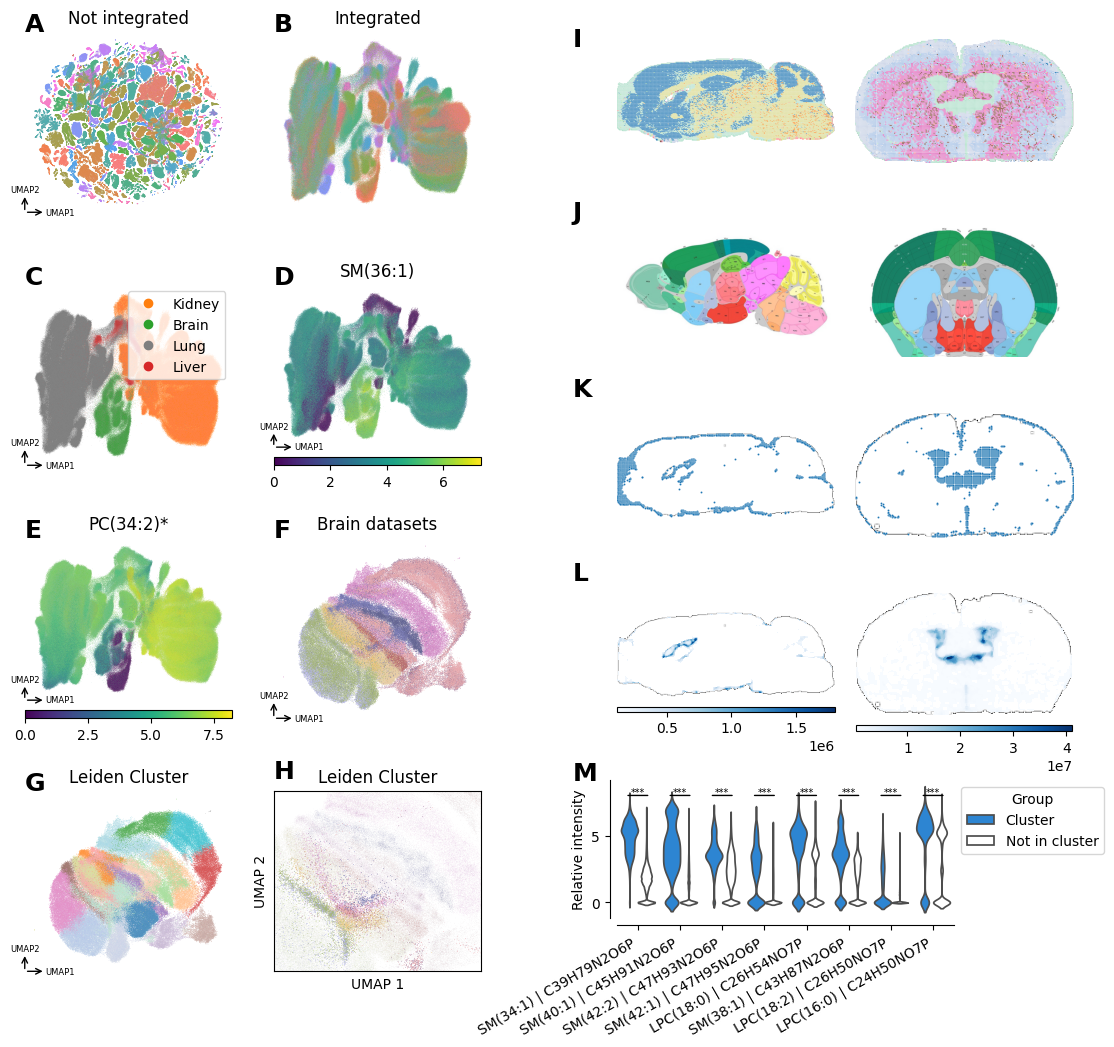

In [28]:
from scipy import ndimage
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(30*cm, 31*cm))
(sub1, sub2) = fig.subfigures(1, 2, hspace=0.02, wspace=.005)

# Subplots
axs1 = sub1.subplots(4, 2)
sub1.subplots_adjust(hspace=0.4)

gs = plt.GridSpec(6, 4)
ax_1l = sub2.add_subplot(gs[0, :2])
ax_1r = sub2.add_subplot(gs[0, 2:])
ax_2l = sub2.add_subplot(gs[1, :2])
ax_2r = sub2.add_subplot(gs[1, 2:])
ax_3l = sub2.add_subplot(gs[2, :2])
ax_3r = sub2.add_subplot(gs[2, 2:])
ax_4l = sub2.add_subplot(gs[3, :2])
ax_4r = sub2.add_subplot(gs[3, 2:])
ax_bb = sub2.add_subplot(gs[4, :3])
# ax_b = sub2.add_subplot(gs[2, :])

sub2.subplots_adjust(bottom=0, hspace=.35)

# Not-integrated UMAP colored by dataset
random_order = np.random.permutation(np.arange(ao.shape[0]))
ax = axs1[0, 0]
sns.scatterplot(data=umap_df(ao[random_order, :]).rename(columns={'organ': 'Organ'}), 
                x='umap_x', y='umap_y', hue='ds', ax=ax, s=.05, alpha=.5, legend=False)
ax.set_title('Not integrated')
ax.axis('off')
draw_umapaxis(ax)
ax_ann(sub1, ax, letter='A', size=BIGGER_SIZE, weight='bold')

# Integrated UMAP colored by dataset
ax = axs1[0, 1]
sns.scatterplot(data=umap_df(ao2[random_order, :]).rename(columns={'organ': 'Organ'}), 
                x='umap_x', y='umap_y', hue='ds', ax=ax, s=.05, alpha=.5, legend=False)
ax.set_title('Integrated')
ax.axis('off')
ax_ann(sub1, ax, letter='B', size=BIGGER_SIZE, weight='bold')

# ###############
# ax = axs1[0, 0]
# sns.scatterplot(data=umap_df(ao).rename(columns={'organ': 'Organ'}), 
#                 x='umap_x', y='umap_y', hue='Organ', palette=organ_colors, ax=ax, s=.05, alpha=.5)
# ax.set_title('')
# ax.axis('off')
# draw_umapaxis(ax)
# ax_ann(sub1, ax, letter='A', size=BIGGER_SIZE, weight='bold')
# leg = ax.legend()
# handles, labels = ax.get_legend_handles_labels()
# patches=[]
# for handle, label in zip(handles, labels):
#     patches.append(Line2D([], [], color=handle.get_color(), label=label, linewidth=.5, marker='o', linestyle=''))
# legend = ax.legend(handles=patches)
# ###############


ax = axs1[1, 0]
sns.scatterplot(data=umap_df(ao2).rename(columns={'organ': 'Organ'}), 
                x='umap_x', y='umap_y', hue='Organ', palette=organ_colors, ax=ax, s=.05, alpha=.5)
ax.set_title('')
ax.axis('off')
draw_umapaxis(ax)
ax_ann(sub1, ax, letter='C', size=BIGGER_SIZE, weight='bold')
leg = ax.legend()
handles, labels = ax.get_legend_handles_labels()
patches=[]
for handle, label in zip(handles, labels):
    patches.append(Line2D([], [], color=handle.get_color(), label=label, linewidth=.5, marker='o', linestyle=''))
legend = ax.legend(handles=patches)


ax = axs1[1,1]
tmp = umap_df(ao2, features = ['C41H83N2O6P', 'C42H80NO8P']).rename(columns={'organ': 'Organ'})
im = sns.scatterplot(data=tmp, 
                     x='umap_x', y='umap_y', hue='C41H83N2O6P', palette='viridis', ax=ax, s=.05, alpha=.5, legend=False)
# Colorbar
div = make_axes_locatable(ax)
cax = div.append_axes("bottom", size="5%", pad=0.1)
norm = plt.Normalize(tmp['C41H83N2O6P'].min(), tmp['C41H83N2O6P'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = sub2.colorbar(sm, cax=cax, shrink=0.6, location='bottom')
ax.axis('off')
ax.set_title('SM(36:1)')
draw_umapaxis(ax)
ax_ann(sub1, ax, letter='D', size=BIGGER_SIZE, weight='bold')

ax = axs1[2,0]
tmp = umap_df(ao2, features = ['C41H83N2O6P', 'C42H80NO8P']).rename(columns={'organ': 'Organ'})
ax = sns.scatterplot(data=tmp, 
                     x='umap_x', y='umap_y', hue='C42H80NO8P', palette='viridis', ax=ax, s=.05, alpha=.5, legend=False)
# Colorbar
div = make_axes_locatable(ax)
cax = div.append_axes("bottom", size="5%", pad=0.1)
norm = plt.Normalize(tmp['C42H80NO8P'].min(), tmp['C42H80NO8P'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = sub2.colorbar(sm, cax=cax, shrink=0.6, location='bottom')
ax.axis('off')
ax.set_title('PC(34:2)*')
draw_umapaxis(ax)
ax_ann(sub1, ax, letter='E', size=BIGGER_SIZE, weight='bold')




ax = axs1[2, 1]
sns.scatterplot(data=umap_df(adcbbknn), x='umap_x', y='umap_y', hue='ds', s=.1, ax=ax, legend=False, 
                palette=ds_colors)
ax.set_title('Brain datasets')
ax.axis('off')
draw_umapaxis(ax)
ax_ann(sub1, ax, letter='F', size=BIGGER_SIZE, weight='bold')

ax = axs1[3, 0]
sns.scatterplot(data=umap_df(adcbbknn), x='umap_x', y='umap_y', hue='leiden', s=.1, ax=ax, legend=False, 
                palette=leiden_colors)
ax.set_title('Leiden Cluster')
ax.axis('off')
draw_umapaxis(ax)
ax_ann(sub1, ax, letter='G', size=BIGGER_SIZE, weight='bold')



# Leiden zoom
ax = axs1[3, 1]
tmp = umap_df(adcbbknn)
tmp = tmp[tmp['leiden']=='7']
sns.scatterplot(data=umap_df(adcbbknn), x='umap_x', y='umap_y', hue='ds', s=.1, ax=ax, legend=False, palette=ds_colors, alpha=.1)
sns.scatterplot(data=tmp, x='umap_x', y='umap_y', hue='ds', s=.2, ax=ax, legend=False, palette=ds_colors)
ax.set_title('Leiden Cluster')
ax.set_xticks([])
ax.set_yticks([])
ax_ann(sub1, ax, letter='H', size=BIGGER_SIZE, weight='bold', yoffset=.01)
mins = tmp[['umap_x', 'umap_y']].min()
maxs = tmp[['umap_x', 'umap_y']].max()
ax.set_xlim((mins['umap_x'], maxs['umap_x']))
ax.set_ylim((mins['umap_y'], maxs['umap_y']))
ax.set_ylabel('UMAP 2')
ax.set_xlabel('UMAP 1')

# Right panel
ann_xoffset=.05

# 1. Row: all cluster images
ax = ax_1l
tmp = adcbbknn.obs
tmp = tmp[tmp['ds']=='2021-11-11_11h49m37s']
ax.imshow(image_outline('2021-11-11_11h49m37s'), cmap='Greys')
sns.scatterplot(data=tmp, x="x", y="y", hue='leiden', s=2, ax=ax, legend=False, palette=leiden_colors)
ax.set_aspect('equal')
ax.axis('off')
ax_ann(sub2, ax, letter='I', size=BIGGER_SIZE, weight='bold', yoffset=.01, figleft_align=True, xoffset=ann_xoffset)
ax.invert_xaxis()

ax = ax_1r
tmp = adcbbknn.obs
tmp = tmp[tmp['ds']=='2017-02-17_14h41m43s']
# tmp.loc[:, 'y'] = -tmp['y']
ax.imshow(image_outline('2017-02-17_14h41m43s'), cmap='Greys')
sns.scatterplot(data=tmp, x="x", y="y", hue='leiden', s=2, ax=ax, legend=False, palette=leiden_colors)
ax.set_aspect('equal')
ax.axis('off')
ax.invert_yaxis()

# 2. Row: Allen Brain reference
ax = ax_2l
image = Image.open('drawings/brain_sagittal.jpg')
ax.imshow(image)
ax.set_aspect('equal')
ax.axis('off')
ax_ann(sub2, ax, letter='J', size=BIGGER_SIZE, weight='bold', yoffset=.01, figleft_align=True, xoffset=ann_xoffset)

ax = ax_2r
image = Image.open('drawings/brain_coronal.jpg')
ax.imshow(image)
ax.set_aspect('equal')
ax.axis('off')

# 3. Row: CLuster 7
ax = ax_3l
lclusters = ['7']
tmp = adcbbknn.obs[adcbbknn.obs['leiden'].isin(lclusters)]
dsl = list(set(tmp['ds']))
tmp = min_pixels(tmp, min_pixels=100)
tmp['ds'] = tmp['ds'].astype(str)
ax.imshow(image_outline('2021-11-11_11h49m37s'), cmap='Greys')
tmp = tmp[tmp['ds']=='2021-11-11_11h49m37s']
sns.scatterplot(data=tmp, x='x', y='y', s=2, ax=ax)
ax.set_aspect('equal')
ax.axis('off')
ax.invert_xaxis()
ax_ann(sub2, ax, letter='K', size=BIGGER_SIZE, weight='bold', yoffset=.03, figleft_align=True, xoffset=ann_xoffset)

ax = ax_3r
lclusters = ['7']
tmp = adcbbknn.obs[adcbbknn.obs['leiden'].isin(lclusters)]
dsl = list(set(tmp['ds']))
tmp = min_pixels(tmp, min_pixels=100)
tmp['ds'] = tmp['ds'].astype(str)
tmp = tmp[tmp['ds']=='2017-02-17_14h41m43s']
ax.imshow(image_outline('2017-02-17_14h41m43s'), cmap='Greys')
sns.scatterplot(data=tmp, x='x', y='y', s=2, ax=ax)
ax.set_aspect('equal')
ax.axis('off')
ax.invert_yaxis()


# 4. Row: Ion images
ax = ax_4l
image_out = image_outline('2021-11-11_11h49m37s')
ax.imshow(image_out, cmap='Greys')
tmp = ndimage.median_filter(image_l['2021-11-11_11h49m37s'], size=(3,3))
masked_img = np.ma.masked_where(tmp < 100000, tmp)
# Cbar testing
im = ax.imshow(masked_img, cmap='Blues')
div = make_axes_locatable(ax)
cax = div.append_axes("bottom", size="5%", pad=0.1)
cbar = sub2.colorbar(im, cax=cax, shrink=0.6, location='bottom')
# ##
ax.axis('off')
ax.invert_xaxis()
ax_ann(sub2, ax, letter='L', size=BIGGER_SIZE, weight='bold', yoffset=.01, figleft_align=True, xoffset=ann_xoffset)

ax = ax_4r
image_out = image_outline('2017-02-17_14h41m43s')
ax.imshow(image_out, cmap='Greys')
tmp = ndimage.median_filter(image_l['2017-02-17_14h41m43s'], size=(3,3))
masked_img = np.ma.masked_where(tmp < 100000, tmp)
im = ax.imshow(masked_img, cmap='Blues')
div = make_axes_locatable(ax)
cax = div.append_axes("bottom", size="5%", pad=0.1)
cbar = sub2.colorbar(im, cax=cax, shrink=0.6, location='bottom')
ax.axis('off')
ax.invert_yaxis()

# 5. Row: Significant lipids

ax=ax_bb
plot_sig_rank(ax, ly=8., ty=8.01)
ax.set_xlabel('')
ax.set_ylabel('Relative intensity')
ax_ann(sub2, ax, letter='M', size=BIGGER_SIZE, weight='bold', yoffset=0., figleft_align=True, xoffset=ann_xoffset)


plt.show()


# Figure 2 Suppl. 1

/home/trose/projects/metaspace_evaluation/coloc_utils.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ds_bool = df.groupby('ds').agg('count')['x'] > min_pixels
/home/trose/projects/metaspace_evaluation/coloc_utils.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ds_bool = df.groupby('ds').agg('count')['x'] > min_pixels
/home/trose/.conda/envs/metabolomics2/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


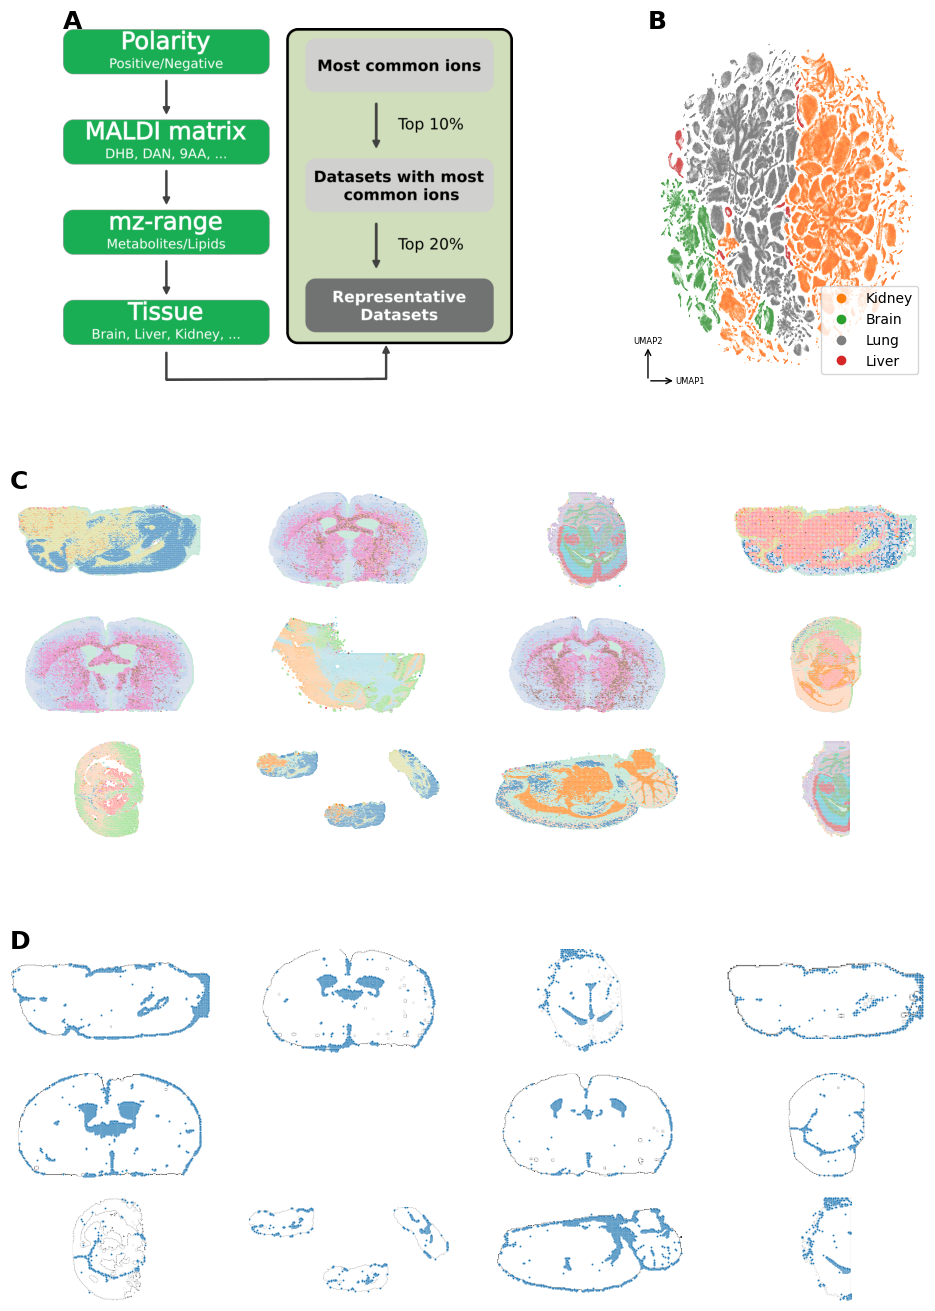

In [33]:
from matplotlib import image
fig = plt.figure(figsize=(30*cm, 35*cm))
(sub0, sub1, sub2) = fig.subfigures(3, 1, hspace=0.005, wspace=.005)


axs1 = sub1.subplots(3, 4).flatten()
axs2 = sub2.subplots(3, 4).flatten()

ax0, ax1 = sub0.subplots(ncols=2, width_ratios=[2,1])
image = image.imread('drawings/representative_datasets.png')
ax0.imshow(image)
ax0.axis('off')
ax_ann(sub0, ax0, letter='A', size=BIGGER_SIZE, weight='bold')


ax = ax1
sns.scatterplot(data=umap_df(ao).rename(columns={'organ': 'Organ'}), 
                x='umap_x', y='umap_y', hue='Organ', palette=organ_colors, ax=ax, s=.05, alpha=.5)
ax.set_title('')
ax.axis('off')
draw_umapaxis(ax)
ax_ann(sub0, ax, letter='B', size=BIGGER_SIZE, weight='bold')
leg = ax.legend()
handles, labels = ax.get_legend_handles_labels()
patches=[]
for handle, label in zip(handles, labels):
    patches.append(Line2D([], [], color=handle.get_color(), label=label, linewidth=.5, marker='o', linestyle=''))
legend = ax.legend(handles=patches)

# All Leiden labels
tmp = adcbbknn.obs
tmp = min_pixels(tmp, min_pixels=100)
dsu = list(set(tmp['ds']))
for ds in range(len(dsu)):
    tt = tmp[tmp['ds']==dsu[ds]]
    sns.scatterplot(data=tt, x='x', y='y', hue='leiden', palette=leiden_colors, ax=axs1[ds], legend=False, s=2)
    axs1[ds].set_aspect('equal')
    axs1[ds].axis('off')

lclusters = ['7']
tmp = adcbbknn.obs[adcbbknn.obs['leiden'].isin(lclusters)]
tmp = min_pixels(tmp, min_pixels=100)
dsu2 = list(set(tmp['ds']))
for ds in range(len(dsu)):
    if dsu[ds] in dsu2:
        tt = tmp[tmp['ds']==dsu[ds]]
        # 
        sns.scatterplot(data=tt, x='x', y='y', ax=axs2[ds], legend=False, s=2)
        axs2[ds].imshow(image_outline(dsu[ds]), cmap='Greys')
        axs2[ds].set_aspect('equal')
    axs2[ds].axis('off')
    axs2[ds].invert_yaxis()

ax_ann(sub1, axs1[0], letter='C', size=BIGGER_SIZE, weight='bold', yoffset=.03)
ax_ann(sub2, axs2[0], letter='D', size=BIGGER_SIZE, weight='bold', yoffset=.03)

plt.show()